In [1]:
import torch
import numpy as np

In [2]:
dirpath = 'Cardiac-Video-Sequence/' # Change to location of this folder on your device
data = np.load(dirpath+'2023-11-15-cine-myo-masks-and-TOS.npy', allow_pickle=True)

In [3]:
# refactor data
X = []
Y = []
bad_data = []
for entry in data:
    x_i = entry['cine_lv_myo_masks_cropped']
    y_i = entry['TOS']
    
    x_i = np.transpose(x_i, (2, 0, 1))
    
    
    if x_i.shape == (25,80,80):
        X.append(x_i)
        Y.append(y_i)
    else:
        bad_data.append(x_i)

X = np.array(X)
Y = np.array(Y)

In [4]:
(X.shape, Y.shape, len(bad_data))

((113, 25, 80, 80), (113, 126), 15)

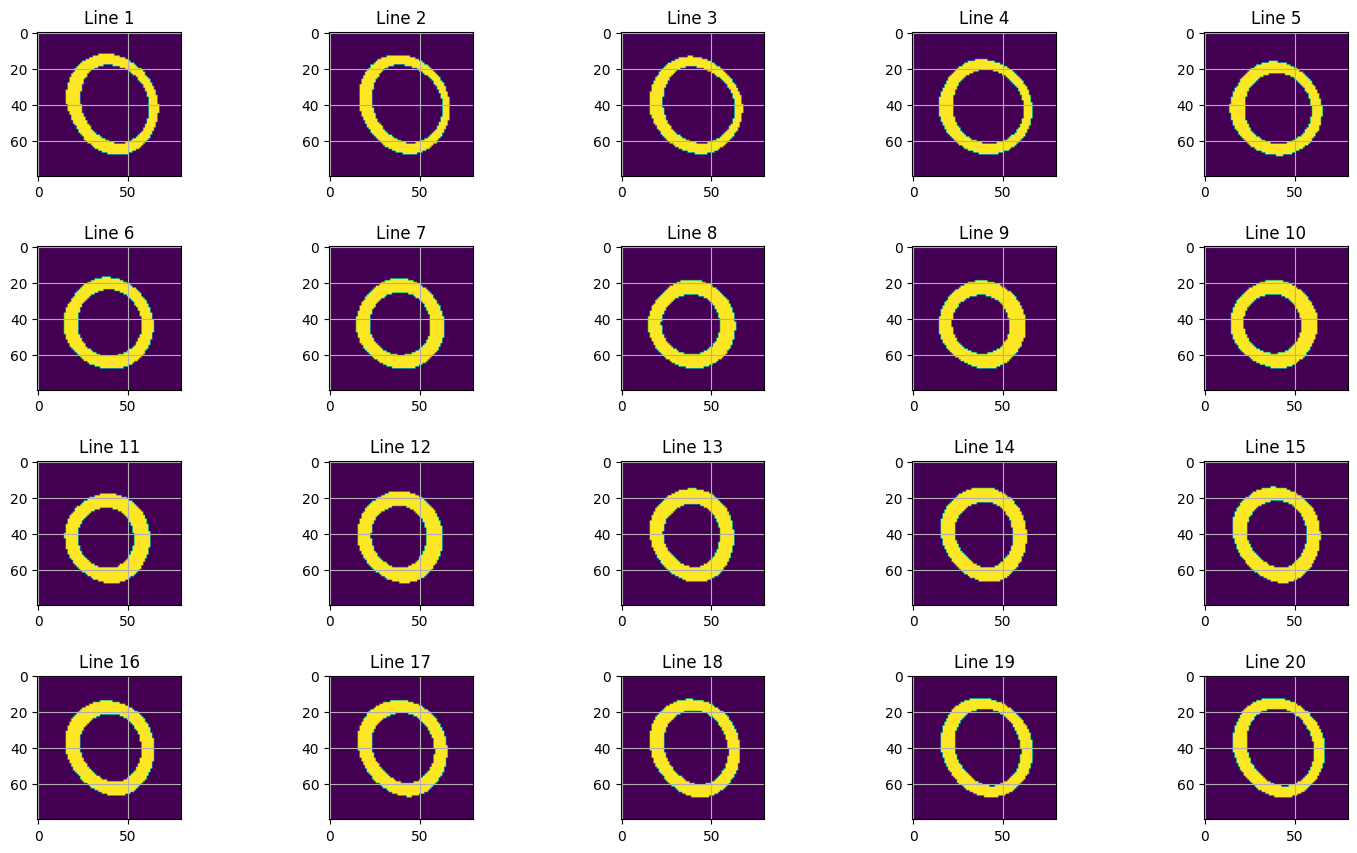

In [5]:
import matplotlib.pyplot as plt

bad_video_sample = bad_data[0]
fig, axes = plt.subplots(4, 5, figsize=(15, 9))  # Adjust figsize as needed
fig.tight_layout(pad=3.0)  # Add padding between subplots

# Plot each line in its respective subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(bad_video_sample[i])
    ax.set_title(f'Line {i+1}')
    ax.grid(True)

# Show the plot
plt.show()

## Data looks fine but is missing 5 frames, for now we will omit and revisit this when we have a good strategy to integrate all 15 of the 20-frame videos into our majority 25-frame video dataset

In [14]:
is_flat = np.all(Y == Y[:, 0][:, np.newaxis], axis=1)

In [15]:
np.sum(is_flat) # Just 1

1

In [16]:
X = X[~is_flat]
Y = Y[~is_flat]

In [29]:
(X.shape, Y.shape)

((112, 25, 80, 80), (112, 126))

In [31]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
torch.save(X_tensor, dirpath+'X_tensor.pt')
torch.save(Y_tensor, dirpath+'Y_tensor.pt')

In [32]:
Y_normal = (Y - np.min(Y)) / np.max(Y)
torch.save(Y_tensor, dirpath+'Y_tensor_normal.pt')